In [207]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [208]:
import pandas as pd
import numpy as np
from numpy import dot
from numpy.linalg import norm
import datetime as dt
import math as mt
from pymongo import MongoClient as mc
import IPython
import IPython.display
from sklearn.decomposition import TruncatedSVD 
from scipy.spatial import distance
import scipy.stats
from modules.models import *
from modules.utils import *
import modules.new_utils as nu
from tqdm import trange
import random as ran

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
matplotlib.rc('font', family='AppleGothic')  # MacOS
# matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

In [209]:
# 1. read datas.xlsx
xlsx = load_excel("datas/datas.xlsx")

In [210]:
# 2. data pre-processing
p, m = data_preprocessing(xlsx)

/Users/formegusto/Desktop/idoformegusto/development/research/contract-recommendation-system/prototype/notebook/modules/utils/data_preprocessing.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  datas_df[household_name] = household_df[col][3:].to_list()
/Users/formegusto/Desktop/idoformegusto/development/research/contract-recommendation-system/prototype/notebook/modules/utils/data_preprocessing.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  month_usage_df[name] = [


In [211]:
# 3. bill - calc
min_per = 10
max_per = 80
bc_result = nu.bill_calc(m, p, min_per, max_per)

1 월 계산 진행 합니다.
가구 수: 398 / 평균: 282 / 표준편차: 107 / 변동계수: 38
2 월 계산 진행 합니다.
가구 수: 398 / 평균: 254 / 표준편차: 91 / 변동계수: 36
3 월 계산 진행 합니다.
가구 수: 398 / 평균: 266 / 표준편차: 91 / 변동계수: 34
4 월 계산 진행 합니다.
가구 수: 398 / 평균: 249 / 표준편차: 86 / 변동계수: 35
5 월 계산 진행 합니다.
가구 수: 398 / 평균: 183 / 표준편차: 126 / 변동계수: 69
6 월 계산 진행 합니다.
가구 수: 398 / 평균: 226 / 표준편차: 84 / 변동계수: 37
7 월 계산 진행 합니다.
가구 수: 398 / 평균: 341 / 표준편차: 133 / 변동계수: 39
8 월 계산 진행 합니다.
가구 수: 398 / 평균: 349 / 표준편차: 140 / 변동계수: 40
9 월 계산 진행 합니다.
가구 수: 398 / 평균: 235 / 표준편차: 85 / 변동계수: 36
10 월 계산 진행 합니다.
가구 수: 398 / 평균: 246 / 표준편차: 88 / 변동계수: 36
11 월 계산 진행 합니다.
가구 수: 398 / 평균: 255 / 표준편차: 94 / 변동계수: 37
12 월 계산 진행 합니다.
가구 수: 398 / 평균: 284 / 표준편차: 111 / 변동계수: 39


In [212]:
# 4. normal_analysis
# 일반분석
# - 각 월 별 유리 가구 수, 아파트 전체 사용요금, 공동설비사용요금, 손실율에서 종합계약이 언제부터 유리해지는 지 확인할 수 있다.
na_result = nu.normal_analysis(bc_result)

In [213]:
print(na_result['pos_change_per'].keys())
print("유리 가구 수 변화",na_result['pos_change_per']['positive_count'])
print("유리 가구 수 변화",na_result['pos_change_per']['loss_ratio'])

dict_keys(['bill', 'public_bill', 'positive_count', 'loss_ratio'])
유리 가구 수 변화 [30. 37. 29. 28. 42. 44. 31. 31. 30. 29. 37. 30.]
유리 가구 수 변화 [30. 37. 26. 24. 37. 44. 30. 30. 23. 25. 37. 30.]


In [214]:
m_idx_month = m.set_index("month")
m_idx_month = m_idx_month.mean().round()
mim = pd.DataFrame(columns=['name', 'usage (kWh)'])
mim['name'] = m_idx_month.index
mim['usage (kWh)'] = m_idx_month.values

In [230]:
m_idx_month = m.set_index("month")
m_idx_month = m_idx_month.mean().round()
mim = pd.DataFrame(columns=['name', 'usage (kWh)'])
mim['name'] = m_idx_month.index
mim['usage (kWh)'] = m_idx_month.values

condition = [
    mim['usage (kWh)'] >= 0, #1. 변화를 주지 않음
    mim['usage (kWh)'] <= 200, #2. 누진세 1단계 가구 집단
    #3. 누진세 2단계 가구 집단
    (mim['usage (kWh)'] <= 400) & (mim['usage (kWh)'] >= 201), 
    (mim['usage (kWh)'] >= 401), #4. 누진세 3단계 가구 집단
    #5. 누진세 1단계 2단계 가구 집단
    ((mim['usage (kWh)'] <= 400) & (mim['usage (kWh)'] >= 201))
    | (mim['usage (kWh)'] <= 200),
    #6. 누진세 1단계 3단계 가구 집단
    (mim['usage (kWh)'] >= 401) | (mim['usage (kWh)'] <= 200),
    mim['usage (kWh)'] >= 0, #1. 변화를 주지 않음 / 2
    mim['usage (kWh)'] <= 200, #2. 누진세 1단계 가구 집단 / 2
    #6. 누진세 1단계 3단계 가구 집단 / 2
    (mim['usage (kWh)'] >= 401) | (mim['usage (kWh)'] <= 200)
]

split_condition = [
    False,
    False,
    False,
    False,
    False,
    False,
    True,
    True,
    True
]

train_datas = pd.DataFrame(columns=['count', 'mean', 'std', 'rsd',
                                    'bill_per', 'public_bill_per',
                                    'pos_cnt_per', 'loss_ratio_per'
                                   ])

for idx,cond in enumerate(condition):
    in_m = pd.DataFrame()
    cond_m = mim[cond]
    if split_condition[idx] == True:
        cond_m = cond_m[:round(len(cond_m) / 2)]
    in_m = m[cond_m.name]
    in_m['month'] = m['month']
             
    bc_result = nu.bill_calc(in_m, p, min_per, max_per)
    IPython.display.clear_output()
    
    print("분석 시작 합니다.")
    na_result = nu.normal_analysis(bc_result)
    
    bills_per = na_result['pos_change_per']['bill']
    public_bills_per = na_result['pos_change_per']['public_bill']
    positive_count_per = na_result['pos_change_per']['positive_count']
    loss_ratio_per = na_result['pos_change_per']['loss_ratio']    
    
    for idx,info in enumerate(bc_result['information']):
        info.update({
            'bill_per':bills_per[idx], 
            'public_bill_per': public_bills_per[idx],
            'pos_cnt_per': positive_count_per[idx], 
            'loss_ratio_per': loss_ratio_per[idx]
        })
        train_datas = train_datas.append(info, ignore_index=True)
        


print("랜덤 선정 시작합니다.")

for idx in range(0,40):
    print("ran#{}".format(idx))
    ran_per = ran.randrange(3,9) / 10
    print("ran_per:{}".format(ran_per))
    test_indices = np.random.rand(len(m_idx_month)) < ran_per

    cond_m = mim[test_indices]
    in_m = m[cond_m.name]
    in_m['month'] = m['month']

    bc_result = nu.bill_calc(in_m, p, min_per, max_per)
    IPython.display.clear_output()

    print("분석 시작 합니다.")
    na_result = nu.normal_analysis(bc_result)

    bills_per = na_result['pos_change_per']['bill']
    public_bills_per = na_result['pos_change_per']['public_bill']
    positive_count_per = na_result['pos_change_per']['positive_count']
    loss_ratio_per = na_result['pos_change_per']['loss_ratio']    

    for idx,info in enumerate(bc_result['information']):
        info.update({
            'bill_per':bills_per[idx], 
            'public_bill_per': public_bills_per[idx],
            'pos_cnt_per': positive_count_per[idx], 
            'loss_ratio_per': loss_ratio_per[idx]
        })
        train_datas = train_datas.append(info, ignore_index=True)
        
train_datas

분석 시작 합니다.


,count,mean,std,rsd,bill_per,public_bill_per,pos_cnt_per,loss_ratio_per
0,398.0,282.0,107.0,38.0,30.0,17.0,30.0,30.0
1,398.0,254.0,91.0,36.0,37.0,12.0,37.0,37.0
2,398.0,266.0,91.0,34.0,31.0,10.0,29.0,26.0
3,398.0,249.0,86.0,35.0,29.0,10.0,28.0,24.0
4,398.0,183.0,126.0,69.0,43.0,29.0,42.0,37.0
...,...,...,...,...,...,...,...,...
583,248.0,344.0,139.0,40.0,35.0,24.0,33.0,32.0
584,248.0,230.0,86.0,37.0,34.0,10.0,34.0,29.0
585,248.0,241.0,90.0,37.0,34.0,10.0,34.0,30.0
586,248.0,249.0,95.0,38.0,38.0,22.0,38.0,38.0


In [233]:
train_datas.to_csv("result.csv")

## 체크 방법
- 데이터에 변형을 줘서 200개의 케이스의 데이터 생성
    - 1개의 케이스당 12개의 케이스 뽑아낼 수 있음.
    - 월 별 ,평균, 표준편차, 변동계수
- 평균, 표준편차, 변동계수, 

In [235]:
df = pd.read_csv("result.csv")

In [236]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plot
from tensorflow import feature_column
from tensorflow.keras import layers
import tensorflow as tf

In [237]:
# 판다스 데이터프레임으로부터 tf.data 데이터셋을 만들기 위한 함수
def df_to_dataset(dataframe, target, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop(target)
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
#   if shuffle:
#     ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(len(dataframe))
  return ds

In [238]:
test_indices = np.random.rand(len(df)) < 0.10
test_indices

train_df = df[~test_indices]
test_df = df[test_indices]

In [66]:
ds = df_to_dataset(df, 'pos_cnt_per', batch_size=5)

In [67]:
# 특성 열을 시험해 보기 위해 샘플 배치를 만듭니다.
example_batch = next(iter(ds))[0]

In [68]:
# 특성 열을 만들고 배치 데이터를 변환하는 함수
def demo(feature_column):
    feature_layer = layers.DenseFeatures(feature_column)
    
    return feature_layer(example_batch).numpy()

In [170]:
rsd = feature_column.numeric_column("rsd")

In [191]:
boundaries = np.array([10,20,30,40,50,60])
rsd_buckets = feature_column.bucketized_column(rsd, boundaries=list(boundaries))

# print("층 지나기 전",example_batch['rsd'].numpy())
# print("층 지난 후",demo(rsd_buckets))
rsd_bucs = demo(rsd_buckets)

rsds = np.array([])
for r in rsd_bucs:
    idx = np.where(r == 1)[0]
    rsds = np.append(rsds, idx)

In [192]:
counts = feature_column.numeric_column("count")
boundaries = np.array([50,100,150,200,250,300])
count_buckets = feature_column.bucketized_column(counts, boundaries=list(boundaries))

In [248]:
X = np.append(X,rsd_bucs, axis=1)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 588 and the array at index 1 has size 108

In [270]:
X = df[['mean', 'std', 'rsd','public_bill_per']].to_numpy().copy()
y = df[['loss_ratio_per']].to_numpy().copy()

In [271]:
rsd_bucs.shape

(108, 7)

In [272]:
wineNames = np.array(['mean', 'std', 'rsd','public_bill_per'])
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.1, random_state=531)
print(len(Xtrain), len(Xtest))

529 59


In [273]:
mseOos = []
nTreeList = range(1, 20, 1)

for iTrees in nTreeList:
    depth = None
    maxFeat = 4 #조정해볼 것
    wineRFModel = ensemble.RandomForestRegressor(n_estimators=iTrees,
                    max_depth=depth, max_features=maxFeat,
                    oob_score=False, random_state=531)
    wineRFModel.fit(Xtrain, ytrain.ravel())
    #데이터 세트에 대한 MSE 누적
    prediction = wineRFModel.predict(Xtest)
    mseOos.append(mean_squared_error(ytest, prediction))
print("MSE")
print(mseOos)

MSE
[29.71186440677966, 37.8771186440678, 24.092801841389413, 15.201565442561204, 11.181751412429376, 16.055987131198997, 13.486106306929551, 13.494997645951035, 11.783171746762456, 11.658719397363464, 12.219374017525022, 11.189906361163427, 10.27347084322313, 10.909289845881855, 10.258658715212386, 11.056219470927495, 10.413155956965703, 10.703113738346005, 10.952457340198551]


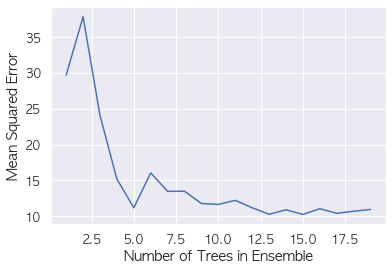

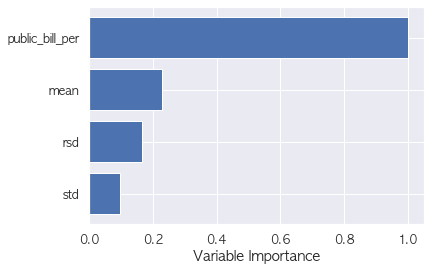

In [274]:
plot.plot(nTreeList, mseOos)
plot.xlabel('Number of Trees in Ensemble')
plot.ylabel('Mean Squared Error')
#plot.ylim([0.0, 1.1*max(mseOob)])
plot.show()

#피처 중요도 도표 그리기
featureImportance = wineRFModel.feature_importances_

#가장 높은 중요도 기준으로 스케일링
featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])+.5
plot.barh(barPos, featureImportance[sorted_idx], align='center')
plot.yticks(barPos, wineNames[sorted_idx])
plot.xlabel('Variable Importance')
plot.show()